In [1]:
import psi4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from scf_guess.io import load_molecule
from scf_guess.metrics import f_score

In [2]:
psi4.set_memory("2 GB")
psi4.set_num_threads(8)
psi4.core.be_quiet()


  Memory set to   1.863 GiB by Python driver.
  Threads set to 8 by Python driver.


In [3]:
xyz_paths = glob("../data/test_data/geometries/**/*.xyz")
print(f"Found {len(xyz_paths)} molecules")

Found 261 molecules


In [4]:
singlets = []
nonsinglets = []

for i, xyz_path in enumerate(xyz_paths):
    mol = load_molecule(xyz_path, disable_symmetry=True)
    if not mol.molecular_charge() == 0:
        print(f"{xyz_path} skipped because not charge neutral.")
        continue
    if mol.multiplicity() == 1:
        singlets.append(xyz_path)
    else:
        nonsinglets.append(xyz_path)

assert len(singlets) == 222
assert len(nonsinglets) == 37

../data/test_data/geometries/vanLenthe2006/CrO4_2-.xyz skipped because not charge neutral.
../data/test_data/geometries/vanLenthe2006/Co(NH3)6.xyz skipped because not charge neutral.


In [5]:
def calculate_guess(mol, guess="SAD"):
    try:
        psi4.set_options({"basis": "pcseg-0", "GUESS": guess})
        # Build the guess density
        basis = psi4.core.BasisSet.build(
            mol, target=psi4.core.get_global_option("BASIS")
        )
        ref_wfn = psi4.core.Wavefunction.build(mol, basis)
        start_wfn = psi4.driver.scf_wavefunction_factory(
            name="hf",
            ref_wfn=ref_wfn,
            reference="RHF" if mol.multiplicity == 1 else "UHF",
        )
        start_wfn.form_H()
        start_wfn.form_Shalf()
        start_wfn.guess()
    finally:
        psi4.core.clean()
    return start_wfn.Da_subset("AO").np, start_wfn.Db_subset("AO").np

In [6]:
def load_reference(path):
    wfn = psi4.core.Wavefunction.from_file(path)
    Da, Db = wfn.Da_subset("AO").np, wfn.Db_subset("AO").np
    S = psi4.core.Matrix(*Da.shape)
    S.remove_symmetry(wfn.S(), wfn.aotoso().transpose())
    return Da, Db, S

In [7]:
def score_data_set(paths, guess="SAD"):
    f_scores = np.empty(len(paths))
    f_scores.fill(np.nan)

    for i, xyz_path in enumerate(paths):
        mol = load_molecule(xyz_path, disable_symmetry=True)
        s = xyz_path.split("/")
        subset = s[-2]
        name = s[-1].removesuffix(".xyz")
        wfn_path = f"../data/test_data/wavefunctions/HF/pcseg-0/{subset}/{name}.npy"
        Da_guess, Db_guess = calculate_guess(mol, guess=guess)
        Da_scf, Db_scf, S = load_reference(wfn_path)
        f_scores[i] = f_score(S, Da_scf, Da_guess, Db_scf, Db_guess)
    return f_scores

| pcseg-0 | singlets | singlets | nonsinglets | nonsinglets |
| ------- | -------- | -------- | ----------- | ----------- | 
| guess   | min $f$  | mean $f$ | min $f$     | mean $f$    |
| GWH     | 0.405    | 0.587    | 0.458       | 0.558       | 
| CORE    | 0.523    | 0.680    | 0.557       | 0.662       | 
| SAD     | 0.711    | 0.908    | 0.739       | 0.871       | 
| SADNO   | 0.758    | 0.973    | 0.861       | 0.959       |
| HUCKEL  | 0.950    | 0.979    | 0.868       | 0.974       |
| CHA-X   | 0.897    | 0.980    | 0.843       | 0.976       |

In [8]:
# Reproduce using the tables S5 and S6 from the SI
ref_guesses = ["GWH", "CORE", "SAD", "SADNO", "HUCKEL", "CHA-X"]
ref_singlets = pd.read_csv(f"../data/reference_tables/Table_S5.csv", index_col=0)
assert len(ref_singlets) == len(singlets)
ref_nonsinglets = pd.read_csv(f"../data/reference_tables/Table_S6.csv", index_col=0)
assert len(ref_nonsinglets) == len(nonsinglets)

pd.DataFrame.from_dict(
    {
        "singlets min": ref_singlets[ref_guesses].min().round(3),
        "singlets mean": ref_singlets[ref_guesses].mean().round(3),
        "nonsinglets min": ref_nonsinglets[ref_guesses].min().round(3),
        "nonsinglets mean": ref_nonsinglets[ref_guesses].mean().round(3),
    }
)

,singlets min,singlets mean,nonsinglets min,nonsinglets mean
GWH,0.405,0.587,0.458,0.558
CORE,0.523,0.680,0.557,0.662
SAD,0.711,0.908,0.739,0.871
SADNO,0.758,0.973,0.861,0.959
HUCKEL,0.950,0.979,0.901,0.964
CHA-X,0.897,0.980,0.843,0.976


In [9]:
# WARNING: this takes quite long
guesses = ["GWH", "CORE", "SAD", "SADNO", "HUCKEL", "SAP"]
f_singlets = {"Molecule": [s.split("/")[-1].rstrip(".xyz") for s in singlets]}
f_nonsinglets = {"Molecule": [s.split("/")[-1].rstrip(".xyz") for s in nonsinglets]}

for guess in guesses:
    print(f"Evaluating {guess}...")
    f_singlets[guess] = score_data_set(singlets, guess=guess)
    f_nonsinglets[guess] = score_data_set(nonsinglets, guess=guess)
f_singlets = pd.DataFrame.from_dict(f_singlets).set_index("Molecule")
f_nonsinglets = pd.DataFrame.from_dict(f_nonsinglets).set_index("Molecule")

Evaluating GWH...
Evaluating CORE...
Evaluating SAD...
Evaluating SADNO...
Evaluating HUCKEL...
Evaluating SAP...


In [10]:
# Just for output:
pd.DataFrame.from_dict(
    {
        "singlets min": f_singlets[guesses].min().round(3),
        "singlets mean": f_singlets[guesses].mean().round(3),
        "nonsinglets min": f_nonsinglets[guesses].min().round(3),
        "nonsinglets mean": f_nonsinglets[guesses].mean().round(3),
    }
)

,singlets min,singlets mean,nonsinglets min,nonsinglets mean
GWH,0.788,0.922,0.791,0.905
CORE,0.523,0.680,0.565,0.663
SAD,0.711,0.908,0.739,0.871
SADNO,0.725,0.974,0.818,0.959
HUCKEL,0.950,0.981,0.910,0.968
SAP,0.876,0.972,0.923,0.971


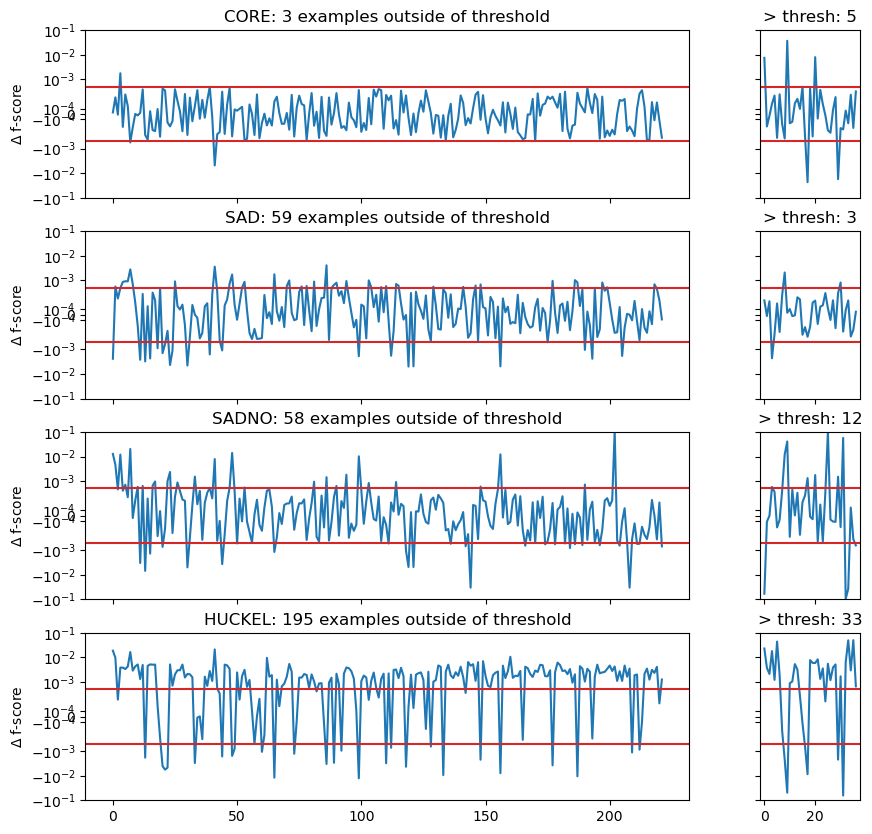

In [14]:
plot_guesses = ["CORE", "SAD", "SADNO", "HUCKEL"]

fig, axes = plt.subplots(
    figsize=(10, 10),
    ncols=2,
    nrows=len(plot_guesses),
    sharex="col",
    sharey=True,
    gridspec_kw={"width_ratios": [len(singlets), len(nonsinglets)]},
)

thresh = 0.0005
for (ax_singlet, ax_nonsinglet), guess in zip(axes, plot_guesses):
    diff_singlet = (
        f_singlets.loc[ref_singlets.index][guess].values - ref_singlets[guess].values
    )

    ax_singlet.plot(diff_singlet)
    ax_singlet.axhline(thresh, color="C3")
    ax_singlet.axhline(-thresh, color="C3")
    ax_singlet.set_title(
        f"{guess}: {np.count_nonzero(abs(diff_singlet) > thresh)} examples outside of threshold"
    )
    ax_singlet.set_yscale("symlog", linthresh=thresh)
    ax_singlet.set_ylim(-0.1, 0.1)
    ax_singlet.set_ylabel("$\\Delta$ f-score")

    diff_nonsinglet = (
        f_nonsinglets.loc[ref_nonsinglets.index][guess].values
        - ref_nonsinglets[guess].values
    )

    ax_nonsinglet.plot(diff_nonsinglet)
    ax_nonsinglet.axhline(thresh, color="C3")
    ax_nonsinglet.axhline(-thresh, color="C3")
    ax_nonsinglet.set_title(
        f"> thresh: {np.count_nonzero(abs(diff_nonsinglet) > thresh)}"
    )
    ax_nonsinglet.set_yscale("symlog", linthresh=thresh)
    ax_nonsinglet.set_ylim(-0.1, 0.1)


In [12]:
guess = "CORE"
diff_singlet = (
    f_singlets.loc[ref_singlets.index][guess].values - ref_singlets[guess].values
)
print(ref_singlets.index[np.where(abs(diff_singlet) > thresh)])

Index(['Ni(C5H5)NO', 'Cr(NO)4', 'MnO3F'], dtype='object', name='Molecule')


In [13]:
guess = "CORE"
diff_nonsinglet = (
    f_nonsinglets.loc[ref_nonsinglets.index][guess].values
    - ref_nonsinglets[guess].values
)
print(ref_nonsinglets.index[np.where(abs(diff_nonsinglet) > thresh)])

Index(['ch', 'cf', 'clo', 'sif', 'no'], dtype='object', name='Molecule')
